# <span>Projet 7 : Implémentez un modèle de scoring </span></center>

In [3]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

# <a id='1'>1. Introduction</a>

----------------------------------------------------------------------------------------------------------------------------
Les données sont issues d'un concours organisé sur Kaggle par l'entreprise "**Home Credit**".

Home Credit est un service dédié à la fourniture de prêts à la population non bancarisée.
Prédire si un client remboursera ou non un prêt ou s'il aura des difficultés est un besoin commercial essentiel,
et Home Credit organise cette compétition sur Kaggle pour voir quel type de modèles la communauté
de l'apprentissage automatique peut développer pour l'aider dans cette tâche.

Il y a 7 sources de données différentes :

   *  **application_train/application_test** : les principales données de train et de test avec des informations sur chaque demande de prêt chez Home Credit. Chaque prêt a sa propre ligne et est identifié par la caractéristique SK_ID_CURR. Les données de train sont accompagnées de la caractéristique TARGET indiquant 0 : le prêt a été remboursé ou 1 : le prêt n'a pas été remboursé.
   
   
   *  **bureau** : données concernant les crédits antérieurs du client auprès d'autres institutions financières. Chaque crédit précédent a sa propre ligne dans bureau, mais un prêt existant dans application_(train|test) peut avoir plusieurs crédits précédents.
   
   
   *  **bureau_balance** : données mensuelles concernant les crédits précédents dans bureau. Chaque ligne correspond à un mois de crédit précédent, et un crédit précédent unique peut avoir plusieurs lignes, une pour chaque mois de la durée du crédit.
   
   
  * **previous_application** : demandes précédentes de prêts a Home Credit des clients qui ont des prêts dans les données de application_(train|test). Chaque prêt actuel dans les données de application_(train|test) peut avoir plusieurs prêts précédents. Chaque demande précédente a une ligne et est identifiée par la caractéristique SK_ID_PREV.
  
  
  * **POS_CASH_BALANCE** : données mensuelles sur les prêts au point de vente ou en espèces que les clients ont eu avec Home Credit. Chaque ligne correspond à un mois d'un prêt au point de vente ou d'un prêt en espèces précédent, et un seul prêt précédent peut avoir plusieurs lignes.
  
  
  * **credit_card_balance** : données mensuelles sur les cartes de crédit que les clients ont eu avec Home Credit. Chaque ligne correspond à un mois de solde de carte de crédit, et une seule carte de crédit peut avoir plusieurs lignes.
  
  
  *  **installments_payment** : historique des paiements pour les prêts précédents chez Home Credit. Il y a une ligne pour chaque paiement effectué et une ligne pour chaque paiement manqué.

_________________


# <a id='2'>2. Importation des librairies</a>

In [4]:
import numpy as np
import pandas as pd
import math
import time
import matplotlib.pyplot as plt
import gc
from contextlib import contextmanager
import importlib
import pickle
import mlflow
import shap
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, learning_curve
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
import re

from evidently.report import Report
from evidently.metrics import DataDriftTable, DatasetDriftMetric
pd.options.display.max_columns = 200
np.random.seed(0)

# <a id='3'>3. Connexion serveur MLflow en local </a>

-  MLflow permet de se connecter au serveur pour le suivi des expériences de machine learning.

- Serveur MLflow en local : Si vous utilisez le serveur MLflow en local, l'adresse est généralement http://127.0.0.1:5000/ par défaut. Cela signifie que le serveur MLflow est accessible sur votre ordinateur local (localhost) via le port 5000. Vous pouvez ouvrir votre navigateur et accéder à cette adresse pour voir l'interface utilisateur MLflow.

In [5]:
# Connexion en local
mlflow.set_tracking_uri('http://127.0.0.1:5000/')


# <a id="4">4. Feature engineering </a>

kernel Kaggle utilisé : https://www.kaggle.com/code/jsaguiar/lightgbm-with-simple-features/script

In [7]:
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [25]:
'''# CONCURRENCE EN MATIÈRE DE RISQUE DE DÉFAUT DE CRÉDIT À DOMICILE
# La plupart des fonctionnalités sont créées en appliquant les fonctions min, max, moyenne, 
  somme et var à des tables groupées.
# Peu de sélection de fonctionnalités est effectuée et le surajustement peut être un problème 
  puisque de nombreuses fonctionnalités sont liées.
# Les idées clés suivantes ont été utilisées :
# - Diviser ou soustraire des fonctionnalités importantes pour obtenir des taux (comme la rente 
    et le revenu)
# - Dans les données du bureau : créer des fonctionnalités spécifiques pour les crédits actifs et les crédits fermés
# - Dans les applications précédentes : créer des fonctionnalités spécifiques pour les applications approuvées et refusées
# - Modularité : une fonction pour chaque table (sauf bureau_balance et application_test)
# - Encodage one-hot pour les fonctionnalités catégorielles
# Toutes les tables sont jointes avec l'application DF à l'aide de la clé SK_ID_CURR (sauf bureau_balance).
# Vous pouvez utiliser LightGBM avec KFold ou Stratified KFold.'''

@contextmanager
def timer(title):
    '''Fonction calculant le temps d'éxécution d'autres fonctions.
    Keyword arguments:
    title -- titre de la fonction exécutée.
    '''
    t0 = time.time()
    yield
    print("{} - réalisé en {:.0f}s".format(title, time.time() - t0))

def one_hot_encoder(df, nan_as_category = True):
    '''Encodage des variables catégorielles.
    Keyword arguments:
    df -- dataframe
    nan_as_category -- ajout d'une colonne indiquant les NaN (default True)
    Returns:
    df -- dataframe encodé
    new_columns -- nouvelles colonnes créées par l'encodage.
    '''
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category, dtype=int)
    new_columns = [c for c in df.columns if c not in original_columns]
    
    return df, new_columns

def application_train_test(num_rows = None, nan_as_category = False):
    '''Preprocessing de application_train.csv et application_test.csv.
    Keyword arguments:
    num_rows -- nombre de lignes (default None)
    nan_as_category -- ajout d'une colonne indiquant les NaN (default False)
    Returns:
    df -- dataframe mergé et preprocessing réalisé.
    '''
    # Read data and merge
    df = pd.read_csv("C:/Users/Aziz/Documents/projet 7/Data set/application_train.csv", nrows= num_rows)
    test_df = pd.read_csv("C:/Users/Aziz/Documents/projet 7/Data set/application_test.csv", nrows= num_rows)
    print("Taille des données d'entrainement: {}, Taille des données de test: {}".format(len(df), len(test_df)))
    df = pd.concat([df,test_df], ignore_index=True)
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']

    del test_df
    gc.collect()
    
    return df

def bureau_and_balance(num_rows = None, nan_as_category = True):
    '''Preprocessing de bureau.csv et bureau_balance.csv.
    Keyword arguments:
    num_rows -- nombre de lignes (default None)
    nan_as_category -- ajout d'une colonne indiquant les NaN (default True)
    Returns:
    bureau_agg -- dataframe aggregé et preprocessing réalisé.
    '''
    bureau = pd.read_csv('C:/Users/Aziz/Documents/projet 7/Data set/bureau.csv', nrows = num_rows)
    bb = pd.read_csv('C:/Users/Aziz/Documents/projet 7/Data set/bureau_balance.csv', nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    
    return bureau_agg

def previous_applications(num_rows = None, nan_as_category = True):
    '''Preprocessing de previous_applications.csv.
    Keyword arguments:
    num_rows -- nombre de lignes (default None)
    nan_as_category -- ajout d'une colonne indiquant les NaN (default True)
    Returns:
    prev_agg -- dataframe aggregé et preprocessing réalisé.
    '''
    prev = pd.read_csv('C:/Users/Aziz/Documents/projet 7/Data set/previous_application.csv', nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    
    return prev_agg

def pos_cash(num_rows = None, nan_as_category = True):
    '''Preprocessing de POS_CASH_balance.csv.
    Keyword arguments:
    num_rows -- nombre de lignes (default None)
    nan_as_category -- ajout d'une colonne indiquant les NaN (default True)
    Returns:
    pos_agg -- dataframe aggregé et preprocessing réalisé.
    '''
    pos = pd.read_csv('C:/Users/Aziz/Documents/projet 7/Data set/POS_CASH_balance.csv', nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    
    return pos_agg
    
def installments_payments(num_rows = None, nan_as_category = True):
    '''Preprocessing de installments_payments.csv.
    Keyword arguments:
    num_rows -- nombre de lignes (default None)
    nan_as_category -- ajout d'une colonne indiquant les NaN (default True)
    Returns:
    ins_agg -- dataframe aggregé et preprocessing réalisé.
    '''
    ins = pd.read_csv('C:/Users/Aziz/Documents/projet 7/Data set/installments_payments.csv', nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    
    return ins_agg

def credit_card_balance(num_rows = None, nan_as_category = True):
    '''Preprocessing de credit_card_balance.csv.
    Keyword arguments:
    num_rows -- nombre de lignes (default None)
    nan_as_category -- ajout d'une colonne indiquant les NaN (default True)
    Returns:
    cc_agg -- dataframe aggregé et preprocessing réalisé.
    '''
    cc = pd.read_csv('C:/Users/Aziz/Documents/projet 7/Data set/credit_card_balance.csv', nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    
    return cc_agg

In [26]:
num_rows = None
df = application_train_test(num_rows)

with timer("Process bureau and bureau_balance"):
    bureau = bureau_and_balance(num_rows)
    print("Bureau df shape:", bureau.shape)
    df = df.join(bureau, how='left', on='SK_ID_CURR')
    del bureau
    gc.collect()
with timer("Process previous_applications"):
    prev = previous_applications(num_rows)
    print("Previous applications df shape:", prev.shape)
    df = df.join(prev, how='left', on='SK_ID_CURR')
    del prev
    gc.collect()
with timer("Process POS-CASH balance"):
    pos = pos_cash(num_rows)
    print("Pos-cash balance df shape:", pos.shape)
    df = df.join(pos, how='left', on='SK_ID_CURR')
    del pos
    gc.collect()
with timer("Process installments payments"):
    ins = installments_payments(num_rows)
    print("Installments payments df shape:", ins.shape)
    df = df.join(ins, how='left', on='SK_ID_CURR')
    del ins
    gc.collect()
with timer("Process credit card balance"):
    cc = credit_card_balance(num_rows)
    print("Credit card balance df shape:", cc.shape)
    df = df.join(cc, how='left', on='SK_ID_CURR')
    del cc
    gc.collect()

Taille des données d'entrainement: 307511, Taille des données de test: 48744


C:\Users\Aziz\AppData\Local\Temp\ipykernel_13336\3667937411.py:50: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)


Bureau df shape: (305811, 116)
Process bureau and bureau_balance - réalisé en 38s


C:\Users\Aziz\AppData\Local\Temp\ipykernel_13336\3667937411.py:141: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
C:\Users\Aziz\AppData\Local\Temp\ipykernel_13336\3667937411.py:142: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves 

Previous applications df shape: (338857, 249)
Process previous_applications - réalisé en 61s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - réalisé en 29s
Installments payments df shape: (339587, 26)
Process installments payments - réalisé en 47s
Credit card balance df shape: (103558, 141)
Process credit card balance - réalisé en 36s


In [27]:
train_df = df[df['TARGET'].notnull()]
test_df = df[df['TARGET'].isnull()]
print("Taille des données d'entrainement: {}".format(len(train_df)))
print("Taille des données de test: {}".format(len(test_df)))

Taille des données d'entrainement: 307507
Taille des données de test: 48744


In [28]:
train_df.to_csv('train_df.csv', index = False)
test_df.to_csv('test_df.csv', index = False)

In [29]:
print("Taille du train: {}".format(train_df.shape))
print("Taille du test: {}".format(test_df.shape))

Taille du train: (307507, 797)
Taille du test: (48744, 797)


In [32]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 307507 entries, 0 to 307510
Columns: 797 entries, SK_ID_CURR to CC_COUNT
dtypes: float64(622), int32(133), int64(42)
memory usage: 1.7 GB


Nous avons 797 variables. On commence par supprimer celles ayant plus de 50% de valeurs manquantes.

In [36]:
# Suppression des colonnes ayant plus de 50 % de valeurs manquantes
threshold = 0.5  # Seuil de 50 %
train_df = train_df.loc[:, train_df.isnull().mean() <= threshold]

# Afficher les colonnes supprimées (optionnel)
missing_percentages = train_df.isnull().mean()
dropped_columns = missing_percentages[missing_percentages > threshold]
for col, pct in dropped_columns.items():
    print(f"Suppression de la variable {col} avec % de valeurs manquantes {pct:.2f}")

In [39]:
train_df.info() 

<class 'pandas.core.frame.DataFrame'>
Index: 307507 entries, 0 to 307510
Columns: 561 entries, SK_ID_CURR to INSTAL_COUNT
dtypes: float64(386), int32(133), int64(42)
memory usage: 1.1 GB


In [40]:
train_df.shape

(307507, 561)

In [41]:
test_df = test_df[train_df.columns]
print(test_df.shape)

(48744, 561)


Il nous reste désormais 561 variables.

Voyons plus en détail certaines d'entre elles. La variable *'DAYS_BIRTH'* est négative car ce sont les jours enregistrés par rapport à la demande de prêt en cours. Nous allons donc transformer cette variable en nombre positifs représentant des années.

In [42]:
train_df['DAYS_BIRTH'].describe()

count    307507.000000
mean     -16037.027271
std        4363.982424
min      -25229.000000
25%      -19682.000000
50%      -15750.000000
75%      -12413.000000
max       -7489.000000
Name: DAYS_BIRTH, dtype: float64

In [43]:
(train_df['DAYS_BIRTH']/-365).describe()

count    307507.000000
mean         43.937061
std          11.956116
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

In [44]:
train_df['DAYS_BIRTH'] = train_df['DAYS_BIRTH']/-365
test_df['DAYS_BIRTH'] = test_df['DAYS_BIRTH']/-365

In [45]:
# change les valeurs négatives en valeurs positives.
train_df[train_df.columns[(train_df < 0).any()].tolist()] = train_df[
    train_df.columns[(train_df < 0).any()].tolist()]*-1

test_df[test_df.columns[(test_df < 0).any()].tolist()] = test_df[
    test_df.columns[(test_df < 0).any()].tolist()]*-1

In [46]:
train_df['DAYS_ID_PUBLISH'] = train_df['DAYS_ID_PUBLISH'].astype(float)
test_df['DAYS_ID_PUBLISH'] = test_df['DAYS_ID_PUBLISH'].astype(float)

In [47]:
train_df['DAYS_EMPLOYED'].describe()

count    252133.000000
mean       2384.142254
std        2338.327666
min          -0.000000
25%         767.000000
50%        1648.000000
75%        3175.000000
max       17912.000000
Name: DAYS_EMPLOYED, dtype: float64

- Transformation de la variable **TARGET** en entier et supression dans la base test.

In [48]:
train_df['TARGET'] = train_df['TARGET'].astype(int)
test_df = test_df.drop('TARGET',axis=1)

## Traitement des NaN

In [49]:
train_df = train_df.replace(np.inf, np.nan)
test_df = test_df.replace(np.inf, np.nan)

In [50]:
train_df.to_csv('train_df_nan.csv', index = False)
test_df.to_csv('test_df_nan.csv', index = False)

# <a id="5">5. Imputation </a>

Nous allons procéder à l'imputation de nos données en utilisant différentes méthodes simples. Pour les colonnes provenant de l'agrégation, nous remplacerons les valeurs manquantes par *0.0*. Pour les variables quantitatives restantes, nous les remplacerons par leur médiane. Enfin, pour les variables qualitatives/catégorielles, nous les remplacerons par le mode, c'est-à-dire la valeur la plus fréquente.

In [51]:
quanti_col = train_df.select_dtypes(['float64']).columns
quali_col = train_df.select_dtypes(['int64']).columns
# quali_col = quali_col.drop('TARGET')

In [52]:
# imputation des variables quantitatives issues de l'aggrégation
col_agg = train_df.columns[train_df.columns.str.contains('_MIN|_MAX|_MEAN|_VAR|_SUM|_SIZE')]

train_df[col_agg] = train_df[col_agg].fillna(0.0)
test_df[col_agg] = test_df[col_agg].fillna(0.0)

In [53]:
# imputation des variables quantitatives restantes
quanti_col_rest = [col for col in quanti_col if col not in col_agg]
for col in quanti_col_rest:
    median = train_df[col].median()
    train_df[col] = train_df[col].fillna(median)
    test_df[col] = test_df[col].fillna(median)

In [54]:
# imputation des variables qualitatives
for col in quali_col:
    mode = train_df[col].mode()[0]
    train_df[col] = train_df[col].fillna(mode)
    test_df[col] = test_df[col].fillna(mode)

In [60]:
train_df.describe()

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,EXT_SOURCE_3,YEARS_BEGINEXPLUATATION_AVG,FLOORSMAX_AVG,YEARS_BEGINEXPLUATATION_MODE,FLOORSMAX_MODE,YEARS_BEGINEXPLUATATION_MEDI,FLOORSMAX_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,...,PREV_NAME_SELLER_INDUSTRY_XNA_MEAN,PREV_NAME_SELLER_INDUSTRY_nan_MEAN,PREV_NAME_YIELD_GROUP_XNA_MEAN,PREV_NAME_YIELD_GROUP_high_MEAN,PREV_NAME_YIELD_GROUP_low_action_MEAN,PREV_NAME_YIELD_GROUP_low_normal_MEAN,PREV_NAME_YIELD_GROUP_middle_MEAN,PREV_NAME_YIELD_GROUP_nan_MEAN,PREV_PRODUCT_COMBINATION_Card Street_MEAN,PREV_PRODUCT_COMBINATION_Card X-Sell_MEAN,PREV_PRODUCT_COMBINATION_Cash_MEAN,PREV_PRODUCT_COMBINATION_Cash Street: high_MEAN,PREV_PRODUCT_COMBINATION_Cash Street: low_MEAN,PREV_PRODUCT_COMBINATION_Cash Street: middle_MEAN,PREV_PRODUCT_COMBINATION_Cash X-Sell: high_MEAN,PREV_PRODUCT_COMBINATION_Cash X-Sell: low_MEAN,PREV_PRODUCT_COMBINATION_Cash X-Sell: middle_MEAN,PREV_PRODUCT_COMBINATION_POS household with interest_MEAN,PREV_PRODUCT_COMBINATION_POS household without interest_MEAN,PREV_PRODUCT_COMBINATION_POS industry with interest_MEAN,PREV_PRODUCT_COMBINATION_POS industry without interest_MEAN,PREV_PRODUCT_COMBINATION_POS mobile with interest_MEAN,PREV_PRODUCT_COMBINATION_POS mobile without interest_MEAN,PREV_PRODUCT_COMBINATION_POS other with interest_MEAN,PREV_PRODUCT_COMBINATION_POS others without interest_MEAN,PREV_PRODUCT_COMBINATION_nan_MEAN,APPROVED_AMT_ANNUITY_MIN,APPROVED_AMT_ANNUITY_MAX,APPROVED_AMT_ANNUITY_MEAN,APPROVED_AMT_APPLICATION_MIN,APPROVED_AMT_APPLICATION_MAX,APPROVED_AMT_APPLICATION_MEAN,APPROVED_AMT_CREDIT_MIN,APPROVED_AMT_CREDIT_MAX,APPROVED_AMT_CREDIT_MEAN,APPROVED_APP_CREDIT_PERC_MIN,APPROVED_APP_CREDIT_PERC_MAX,APPROVED_APP_CREDIT_PERC_MEAN,APPROVED_APP_CREDIT_PERC_VAR,APPROVED_AMT_DOWN_PAYMENT_MIN,APPROVED_AMT_DOWN_PAYMENT_MAX,APPROVED_AMT_DOWN_PAYMENT_MEAN,APPROVED_AMT_GOODS_PRICE_MIN,APPROVED_AMT_GOODS_PRICE_MAX,APPROVED_AMT_GOODS_PRICE_MEAN,APPROVED_HOUR_APPR_PROCESS_START_MIN,APPROVED_HOUR_APPR_P

In [61]:
train_df.to_csv('train_df_cleaned.csv', index = False)
test_df.to_csv('test_df_cleaned.csv', index = False)

## Quelque statistique des variables après traitement

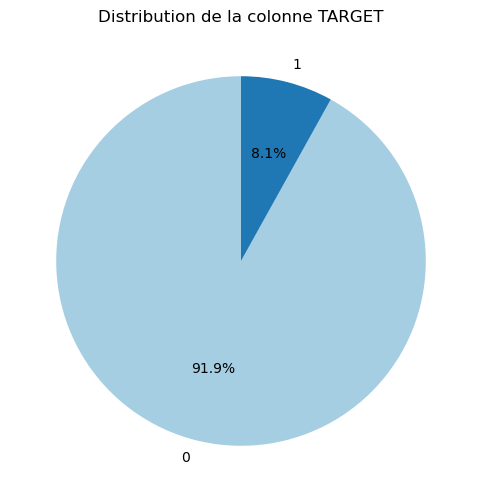

In [62]:
def pie_plot(df, columns):
    """
    Crée un graphique en secteurs pour les colonnes spécifiées.
    :param df: DataFrame pandas
    :param columns: Liste des colonnes à visualiser
    """
    for col in columns:
        # Compter les occurrences de chaque valeur unique
        value_counts = df[col].value_counts()
        
        # Création du pie chart
        plt.figure(figsize=(6, 6))
        plt.pie(
            value_counts, 
            labels=value_counts.index, 
            autopct='%1.1f%%', 
            startangle=90,
            colors=plt.cm.Paired.colors
        )
        plt.title(f"Distribution de la colonne {col}")
        plt.show()

# Exemple d'utilisation
pie_plot(train_df, ['TARGET'])

In [75]:
X = train_df.drop(['TARGET'], axis=1)
y = train_df['TARGET']

In [71]:
# Nous devons retirer les caractères spéciaux des noms des features pour l'utilisation de certains modèles (LightGBM)

X = X.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
test_df = test_df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

Ce code ci-dessous divise les données (X et y) en ensembles d'entraînement (X_train, y_train) et de validation (X_val, y_val) en utilisant la fonction train_test_split() avec un test_size de 20%, une stratification basée sur y et une seed random_state fixée à 0 pour la reproductibilité.

In [72]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, stratify=y, random_state=0)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(246005, 560) (246005,)
(61502, 560) (61502,)


In [73]:
cols = X_train.select_dtypes(['float64']).columns

In [74]:
cols

Index(['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'CNT_FAM_MEMBERS',
       ...
       'INSTAL_AMT_INSTALMENT_MEAN', 'INSTAL_AMT_INSTALMENT_SUM',
       'INSTAL_AMT_PAYMENT_MIN', 'INSTAL_AMT_PAYMENT_MAX',
       'INSTAL_AMT_PAYMENT_MEAN', 'INSTAL_AMT_PAYMENT_SUM',
       'INSTAL_DAYS_ENTRY_PAYMENT_MAX', 'INSTAL_DAYS_ENTRY_PAYMENT_MEAN',
       'INSTAL_DAYS_ENTRY_PAYMENT_SUM', 'INSTAL_COUNT'],
      dtype='object', length=387)